# MMAI 831 Watts AI On The Spot Assignment 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## User preferences

In [2]:
FIGSIZE = (16, 16)
TESTSIZE_IN_PERCENT = 25
RANDOM_SEED = 42

## Load data and clean

In [3]:
# Load data and convert top row to headers
blender_data_raw = pd.read_excel('MMM_Blender_data.xlsx')
headers = blender_data_raw.iloc[0]
blender_data_raw = blender_data_raw[1:]
blender_data_raw.columns = headers

In [4]:
print(blender_data_raw.info())
blender_data_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 1 to 150
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         150 non-null    object
 1   sales_units  150 non-null    object
 2   Price ($)    150 non-null    object
 3   TV_ads       150 non-null    object
 4   online_ads   150 non-null    object
 5   Print_ads    150 non-null    object
dtypes: object(6)
memory usage: 7.2+ KB
None


,Date,sales_units,Price ($),TV_ads,online_ads,Print_ads
1,Jan-2008,924,135,181.223,0.121525,0.249869
2,Feb-2008,906,135,179.104,0.573534,0.175744
3,Mar-2008,1567,135,222.756,1.46794,0.16016
4,Apr-2008,1996,135,188.267,3.76459,0.296897
5,May-2008,917,136.5,210.038,0.212976,0.17607


  - We see that there are no non-null fields so no drops or smoothing
  - The column types are objects that need to be converted into integers
    (sales_units) and floats (the remainder).
  - The column names need standardizing to avoid errors
  - The sales_units column is the DV (the label) and should be branched off
    after the split.
  - The Date field needs to be converted into date_time
  - The ads fields are in thousands of dollars, whereas price is in dollars.
    This is a good thing for TV ads, but the online and print ads are an
    order of magnitude less than TV ads; perhaps they might be bumped up
    100x after the split.

In [5]:
blender_data = blender_data_raw.rename(
    columns = {'Date': 'date', 'Price ($)': 'price', 'TV_ads': 'tv_ads',
               'Print_ads': 'print_ads'}
)
for feature in 'price tv_ads online_ads print_ads'.split():
    blender_data[feature] = blender_data[feature].astype('float64')
blender_data['sales_units'] = blender_data['sales_units'].astype('int32')
blender_data['date'] = pd.to_datetime(blender_data['date'])
blender_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 1 to 150
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         150 non-null    datetime64[ns]
 1   sales_units  150 non-null    int32         
 2   price        150 non-null    float64       
 3   tv_ads       150 non-null    float64       
 4   online_ads   150 non-null    float64       
 5   print_ads    150 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int32(1)
memory usage: 6.6 KB


In [6]:
blender_data.head(5)

,date,sales_units,price,tv_ads,online_ads,print_ads
1,2008-01-01,924,135.0,181.222548,0.121525,0.249869
2,2008-02-01,906,135.0,179.104353,0.573534,0.175744
3,2008-03-01,1567,135.0,222.756223,1.467942,0.160160
4,2008-04-01,1996,135.0,188.266818,3.764595,0.296897
5,2008-05-01,917,136.5,210.038290,0.212976,0.176070


## Inspect the data
### Distribution

array([[<AxesSubplot:title={'center':'sales_units'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'tv_ads'}>,
        <AxesSubplot:title={'center':'online_ads'}>],
       [<AxesSubplot:title={'center':'print_ads'}>, <AxesSubplot:>]],
      dtype=object)

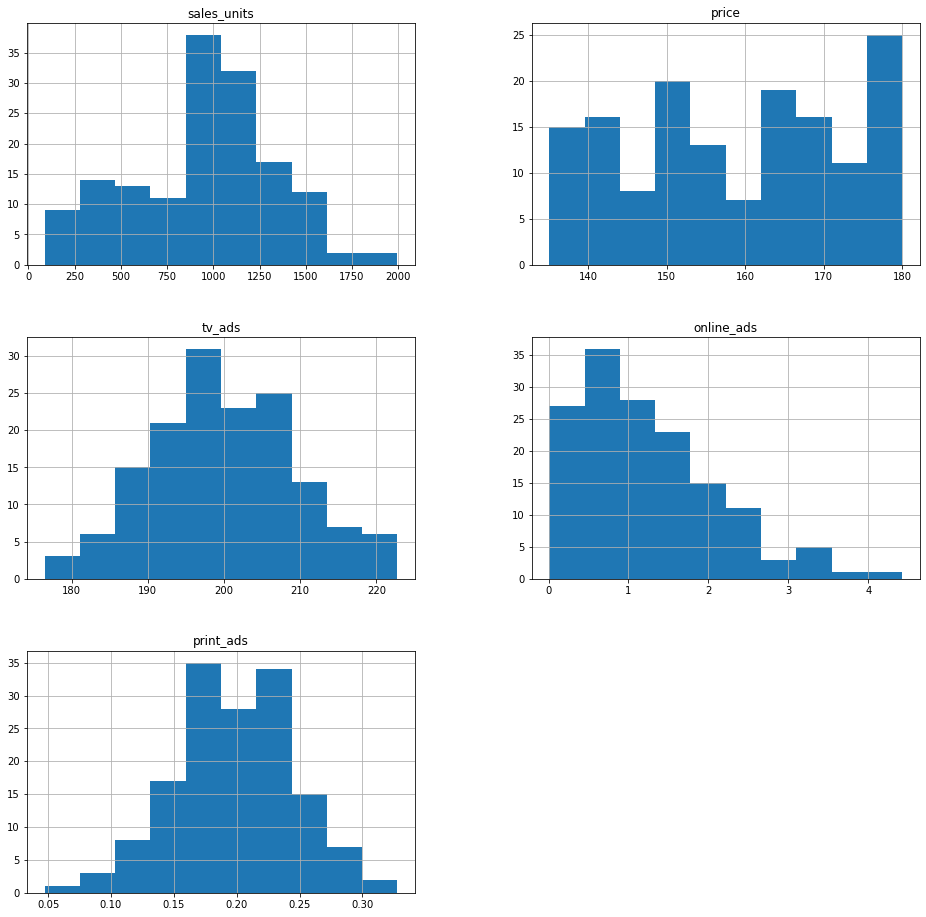

In [7]:
blender_data.drop('date', axis=1).hist(figsize=FIGSIZE)

Online ads skew positive right. A log transformation after the split may
assist.

### Multicollinearity

0            sales_units  price  tv_ads  online_ads  print_ads
0                                                             
sales_units         1.00  -0.62    0.25        0.76       0.17
price              -0.62   1.00   -0.10       -0.06      -0.07
tv_ads              0.25  -0.10    1.00        0.02      -0.05
online_ads          0.76  -0.06    0.02        1.00       0.00
print_ads           0.17  -0.07   -0.05        0.00       1.00


<AxesSubplot:xlabel='0', ylabel='0'>

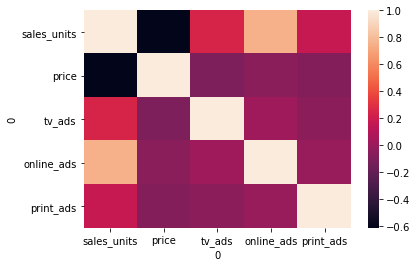

In [8]:
correlation_matrix = blender_data.corr()
print(round(correlation_matrix, 2))  # decimal places
sns.heatmap(correlation_matrix)

There appears to be a correlation between sales units (which is the DV anyway)
and the online ads at 0.76. Price has a negative correlation with sales unit
(the DV) which is hardly a surprise. However, multicollinearity does not
appear to be an issue within the independent variables.

array([[<AxesSubplot:xlabel='sales_units', ylabel='sales_units'>,
        <AxesSubplot:xlabel='price', ylabel='sales_units'>,
        <AxesSubplot:xlabel='tv_ads', ylabel='sales_units'>,
        <AxesSubplot:xlabel='online_ads', ylabel='sales_units'>,
        <AxesSubplot:xlabel='print_ads', ylabel='sales_units'>],
       [<AxesSubplot:xlabel='sales_units', ylabel='price'>,
        <AxesSubplot:xlabel='price', ylabel='price'>,
        <AxesSubplot:xlabel='tv_ads', ylabel='price'>,
        <AxesSubplot:xlabel='online_ads', ylabel='price'>,
        <AxesSubplot:xlabel='print_ads', ylabel='price'>],
       [<AxesSubplot:xlabel='sales_units', ylabel='tv_ads'>,
        <AxesSubplot:xlabel='price', ylabel='tv_ads'>,
        <AxesSubplot:xlabel='tv_ads', ylabel='tv_ads'>,
        <AxesSubplot:xlabel='online_ads', ylabel='tv_ads'>,
        <AxesSubplot:xlabel='print_ads', ylabel='tv_ads'>],
       [<AxesSubplot:xlabel='sales_units', ylabel='online_ads'>,
        <AxesSubplot:xlabel='price', yl

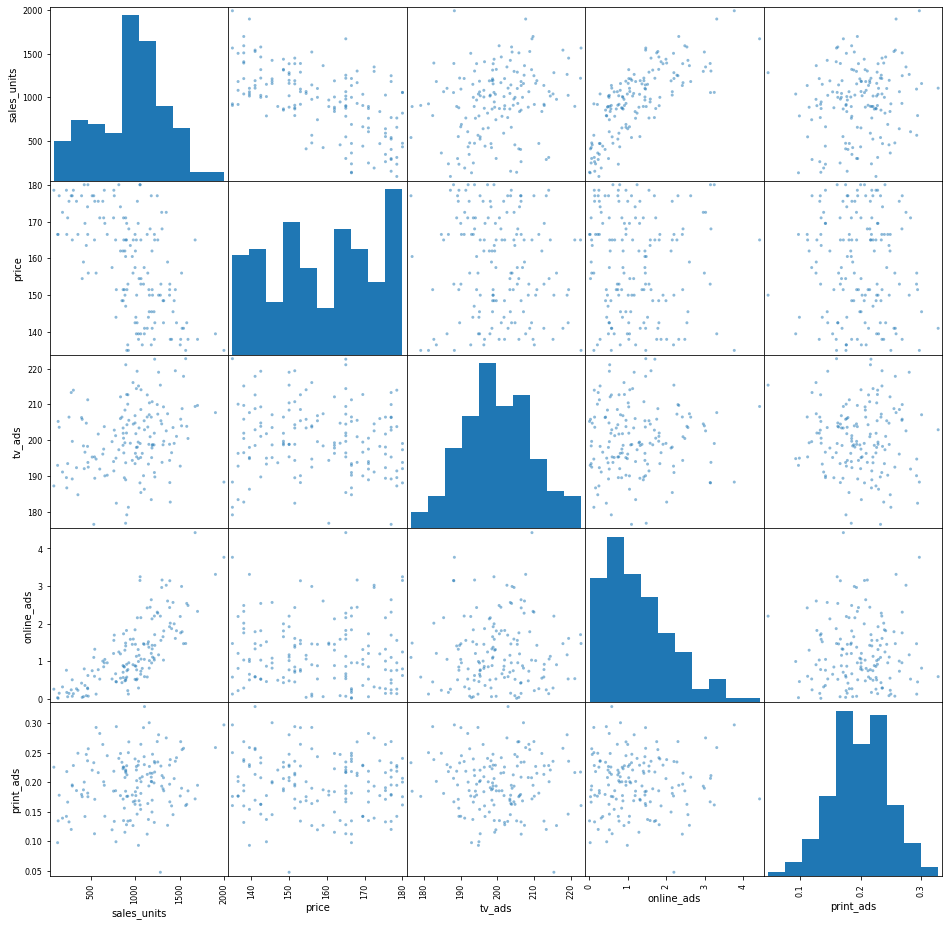

In [9]:
pd.plotting.scatter_matrix(
    blender_data.drop(['date'], axis=1), figsize=FIGSIZE
)

Visual inspection shows lovely, lovely random scatter points, which confirms
the correlation heat matrix. Note that the online ads are positively linear.

## Handy model exploration classes for easy reuse

In [105]:
from abc import ABC  # creates abstract classes
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

class ModelPackage(ABC):
    def __init__(
        self, name: str, X: pd, y: pd, split_test_percentage: int, random_seed=42
    ):
        self.name = name
        self.train_X, self.test_X, self.train_y, self.test_y = \
            train_test_split(X,
                             y,
                             test_size=(split_test_percentage/100),
                             random_state=random_seed)
        self.model = None
        self.in_sample_evaluation = {}
        self.hold_out_evaluation = {}
        self.predictions = {
            'in_sample': None,
            'hold_out': None
        }
        self.scaler = None

    def set_model(self, model):
        self.model = model    
        
    def get_model(self):
        return self.model
    
    def get_name(self):
        return self.name
    
    def get_split(self, identifier: str):
        if hasattr(self, identifier):
            return getattr(self, identifier)
        
    def scale(self):
        mmscaler = MinMaxScaler().fit(self.train_X)
        column_names = self.train_X.columns.values
        self.train_X = pd.DataFrame(
            data=mmscaler.transform(self.train_X),
            columns=column_names
        )
        self.test_X = pd.DataFrame(
            data=mmscaler.transform(self.test_X),
            columns=column_names
        )
        
    def standardize(self):    
        from sklearn.preprocessing import StandardScaler
        self.train_X  = StandardScaler().fit_transform(self.train_X)
        self.test_X = StandardScaler().fit_transform(self.test_X)

        
    def get_predictions(self, identifier: str):
        if identifier == 'train':
            return self.predictions['in_sample']
        elif identifier == 'test':
            return self.predictions['hold_out']
        else:
            return None

    def get_coefficients(self):
        return self.model.coef_.tolist()[0]
    
    def fit(self):
        self.model.fit(self.train_X, self.train_y)
        self.__evaluate_in_sample()
        self.__evaluate_hold_out()
        
    def __evaluate_in_sample(self):
        predict_y = self.model.predict(self.train_X)
        self.in_sample_evaluation = {
            'rmse': mean_squared_error(self.train_y, predict_y, squared=False),
            'r2': r2_score(self.train_y, predict_y),
        }
        self.predictions['in_sample'] = predict_y

    def __evaluate_hold_out(self):
        predict_y = self.model.predict(self.test_X)
        self.hold_out_evaluation = {
            'rmse': mean_squared_error(self.test_y, predict_y, squared=False),
            'r2': r2_score(self.test_y, predict_y)
        }
        self.predictions['hold_out'] = predict_y

    def add_pairwise(self, column_names: list):
        stop = len(column_names) - 1
        i = 0
        while i <= stop:
            j = i + 1
            while j <= stop:
                self.train_X[f"{column_names[i]}:{column_names[j]}"] = \
                    self.train_X[column_names[i]] * self.train_X[column_names[j]]
                self.test_X[f"{column_names[i]}:{column_names[j]}"] = \
                    self.test_X[column_names[i]] * self.test_X[column_names[j]]                
                j += 1
            i += 1        

            
class LinearRegressionModelPackage(ModelPackage):
    def __init__(
        self, name: str, X: pd, y: pd, split_test_percentage: int, random_seed=42
    ):
        super().__init__(name, X, y, split_test_percentage, random_seed)
        self.model = LinearRegression()


class OLSModelPackage(ModelPackage):
    def __init__(
        self, name: str, X: pd, y: pd, split_test_percentage: int, random_seed=42
    ):
        super().__init__(name, X, y, split_test_percentage, random_seed)
        self.model = sm.OLS(self.train_y, self.train_X)
        
    def fit(self):
        self.model = self.model.fit()
        predict_y = self.model.predict(self.train_X)
        self.predictions['in_sample'] = predict_y
        predict_y = self.model.predict(self.test_X)
        self.predictions['hold_out'] = predict_y
    

class ModelReporter:
    def __init__(self, model_package):
        self.model_package = model_package
        
    def summary(self):
        model = self.model_package.get_model()
        if type(model) != \
            statsmodels.regression.linear_model.RegressionResultsWrapper:
            self.print_evaluation()
            self.print_coefficients()
        else:
            print(model.summary())
            
    def print_coefficients(self):
        train_X = self.model_package.get_split('train_X')
        name = self.model_package.get_name()
        print('\nCoefficients')
        col_size = self.__print_header(name, train_X)
        
        coef = [name] + self.model_package.get_coefficients()
        float_formatting = f"{{:<{col_size}}}" + \
            f"{{:<{col_size}.2f}}"*len(train_X.columns)
        print(float_formatting.format(*coef))
 
    @staticmethod
    def __print_header(name: str, train_X: pd) -> int:
        column_headers = ['Name'] + train_X.columns.to_list()
        col_size = max(6, len(name)) # 6 = xxx.xx for float
        for header in column_headers:
            col_size = max(col_size, len(header))
        col_size += 1  # Adds a space
        header_formatting = f"{{:<{col_size}}}"*len(column_headers)
        print(header_formatting.format(*column_headers))
        return col_size

    def print_evaluation(self):
        '''Duplicate what R "summary" gives'''
        print('\nEvaluation')
        
        # In-Sample (i.e., training sample)
        print('In Sample (training): ', end='')
        for key, value in self.model_package.in_sample_evaluation.items():
            print("{}:{:.2f}; ".format(key, value.item()), end='')
            
            
        # Hold Out (i.e., test sample)
        print('\nHold Out (test): ', end='')
        for key, value in self.model_package.hold_out_evaluation.items():
            print("{}:{:.2f}; ".format(key, value.item()), end='')
        print

    def plot(self, train=True):
        # The linear line
        x, y, pred_y = self.__select_results(train)
        y_title = self.__get_title_from_y()        
        name = self.model_package.get_name()
        
        plt.title(f"{name}:{y_title}")
        plt.scatter(x, y, color='blue')
        plt.scatter(x, pred_y, color='red')
        plt.xlabel(name)
        plt.ylabel(y_title)
        plt.show()
        
    def __select_results(self, train: bool):
        selector = 'train' if train else 'test'
        X = self.model_package.get_split(f"{selector}_X")
        y = self.model_package.get_split(f"{selector}_y")
        pred_y = self.model_package.get_predictions(selector)
        return X, y, pred_y

    def __get_title_from_y(self):
        y = self.model_package.get_split('train_y')
        return y.columns[0].replace('_', ' ').title()

        
class ModelExplorer:
    '''Facade Pattern'''
    def __init__(self, model_package: ModelPackage):
        self.model_package = model_package
        self.model_reporter = ModelReporter(model_package)
    
    def execute(self):
        self.model_package.fit()
        self.model_reporter.summary()
        self.model_reporter.plot()
        
    def scale(self):
        self.model_package.scale()

## Explore the unengineered features

No log transformations, no scaling, no added or removed features.

In [14]:
blender_data

,date,sales_units,price,tv_ads,online_ads,print_ads
1,2008-01-01,924,135.0,181.222548,0.121525,0.249869
2,2008-02-01,906,135.0,179.104353,0.573534,0.175744
3,2008-03-01,1567,135.0,222.756223,1.467942,0.160160
4,2008-04-01,1996,135.0,188.266818,3.764595,0.296897
5,2008-05-01,917,136.5,210.038290,0.212976,0.176070
...,...,...,...,...,...,...
146,2020-02-01,1054,180.0,188.038562,3.147389,0.206339
147,2020-03-01,470,180.0,193.748973,0.615831,0.175143
148,2020-04-01,1056,180.0,199.048224,3.245625,0.161226
149,2020-05-01,429,180.0,192.013052,0.791698,0.199933


In [15]:
X = blender_data.drop(['sales_units', 'date', 'price'], axis=1)
y = blender_data[['sales_units']]

In [16]:
ols_model_package = OLSModelPackage(
    'OLS unengineered', X, y, TESTSIZE_IN_PERCENT, RANDOM_SEED
)
ols_model_package.fit()

ols_model_reporter = ModelReporter(ols_model_package)
ols_model_reporter.summary()

                                 OLS Regression Results                                
Dep. Variable:            sales_units   R-squared (uncentered):                   0.944
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              616.1
Date:                Tue, 10 May 2022   Prob (F-statistic):                    3.60e-68
Time:                        23:05:23   Log-Likelihood:                         -773.06
No. Observations:                 112   AIC:                                      1552.
Df Residuals:                     109   BIC:                                      1560.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [17]:
# Using Scikit linear regression
model_baseline = LinearRegressionModelPackage(
    'Unengineered', X, y, TESTSIZE_IN_PERCENT, RANDOM_SEED
)
model_baseline.fit()
model_reporter = ModelReporter(model_baseline)
model_reporter.summary()


Evaluation
In Sample (training): rmse:229.90; r2:0.64; 
Hold Out (test): rmse:225.99; r2:0.70; 
Coefficients
Name         tv_ads       online_ads   print_ads    
Unengineered 8.97         318.08       1433.17      


Apparently:
  - one dollar decrease in price increases sales by 15.85
  - each thousand spent on tv increases sales by 7.5
  - each thousand spent on online increases sales by 322.28
  - each thousand spent on print ads increases sales by 1108.56!
  
We will nest the models.

## Nest 1 to 3: TV, Online, Print, Time


Evaluation
In Sample (training): rmse:369.91; r2:0.06; 
Hold Out (test): rmse:403.95; r2:0.05; 
Coefficients
Name                 tv_ads               
TV Ad Costs in $1000 9.97                 


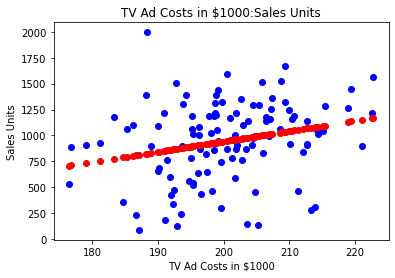

In [18]:
model_tv_explorer = ModelExplorer(
    LinearRegressionModelPackage(
        'TV Ad Costs in $1000', X[['tv_ads']], y, TESTSIZE_IN_PERCENT, RANDOM_SEED
    )
)
model_tv_explorer.execute()

                                 OLS Regression Results                                
Dep. Variable:            sales_units   R-squared (uncentered):                   0.866
Model:                            OLS   Adj. R-squared (uncentered):              0.865
Method:                 Least Squares   F-statistic:                              717.2
Date:                Tue, 10 May 2022   Prob (F-statistic):                    2.93e-50
Time:                        23:22:26   Log-Likelihood:                         -822.24
No. Observations:                 112   AIC:                                      1646.
Df Residuals:                     111   BIC:                                      1649.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

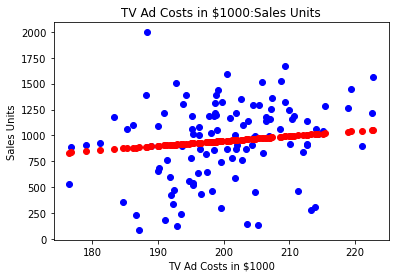

In [19]:
model_tv_explorer = ModelExplorer(
    OLSModelPackage(
        'TV Ad Costs in $1000', X[['tv_ads']], y, TESTSIZE_IN_PERCENT, RANDOM_SEED
    )
)
model_tv_explorer.execute()


Evaluation
In Sample (training): rmse:254.45; r2:0.56; 
Hold Out (test): rmse:259.30; r2:0.61; 
Coefficients
Name                     online_ads               
Online Ad Costs in $1000 319.73                   


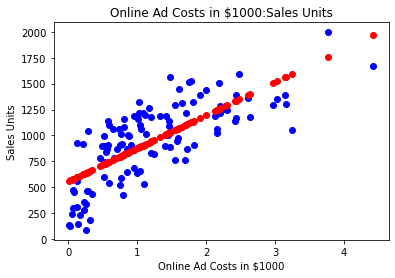

In [20]:
model_online_explorer = ModelExplorer(
    LinearRegressionModelPackage(
        'Online Ad Costs in $1000', X[['online_ads']], y, TESTSIZE_IN_PERCENT, RANDOM_SEED
    )
)
model_online_explorer.execute()

                                 OLS Regression Results                                
Dep. Variable:            sales_units   R-squared (uncentered):                   0.833
Model:                            OLS   Adj. R-squared (uncentered):              0.832
Method:                 Least Squares   F-statistic:                              555.1
Date:                Tue, 10 May 2022   Prob (F-statistic):                    5.32e-45
Time:                        23:22:27   Log-Likelihood:                         -834.44
No. Observations:                 112   AIC:                                      1671.
Df Residuals:                     111   BIC:                                      1674.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

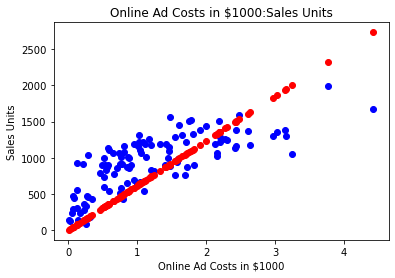

In [21]:
model_online_explorer = ModelExplorer(
    OLSModelPackage(
        'Online Ad Costs in $1000', X[['online_ads']], y, TESTSIZE_IN_PERCENT, RANDOM_SEED
    )
)
model_online_explorer.execute()


Evaluation
In Sample (training): rmse:315.31; r2:0.32; 
Hold Out (test): rmse:293.36; r2:0.50; 
Coefficients
Name                        tick                        
Sales as a function of time -5.06                       


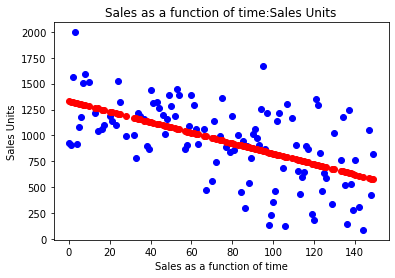

In [22]:
X_time_series = X.copy()
X_time_series.insert(0, 'tick', range(len(X)))
model_date_explorer = ModelExplorer(
    LinearRegressionModelPackage(
        'Sales as a function of time', X_time_series[['tick']], y, TESTSIZE_IN_PERCENT, RANDOM_SEED
    )
)
model_date_explorer.execute()

                                 OLS Regression Results                                
Dep. Variable:            sales_units   R-squared (uncentered):                   0.497
Model:                            OLS   Adj. R-squared (uncentered):              0.493
Method:                 Least Squares   F-statistic:                              109.9
Date:                Tue, 10 May 2022   Prob (F-statistic):                    2.75e-18
Time:                        23:22:32   Log-Likelihood:                         -896.25
No. Observations:                 112   AIC:                                      1794.
Df Residuals:                     111   BIC:                                      1797.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

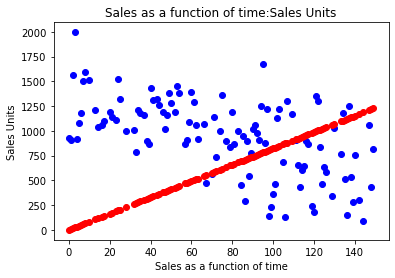

In [23]:
model_date_explorer = ModelExplorer(
    OLSModelPackage(
        'Sales as a function of time', X_time_series[['tick']], y, TESTSIZE_IN_PERCENT, RANDOM_SEED
    )
)
model_date_explorer.execute()

Wow is that ever messed up!


Evaluation
In Sample (training): rmse:377.90; r2:0.02; 
Hold Out (test): rmse:405.57; r2:0.04; 
Coefficients
Name                    print_ads               
Print Ad Costs in $1000 1152.78                 


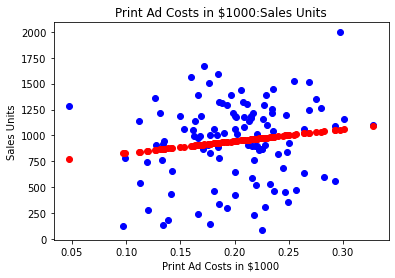

In [24]:
model_print_explorer = ModelExplorer(
    LinearRegressionModelPackage(
        'Print Ad Costs in $1000', X[['print_ads']], y, TESTSIZE_IN_PERCENT, RANDOM_SEED
    )
)
model_print_explorer.execute()

                                 OLS Regression Results                                
Dep. Variable:            sales_units   R-squared (uncentered):                   0.834
Model:                            OLS   Adj. R-squared (uncentered):              0.833
Method:                 Least Squares   F-statistic:                              559.6
Date:                Tue, 10 May 2022   Prob (F-statistic):                    3.65e-45
Time:                        23:22:38   Log-Likelihood:                         -834.06
No. Observations:                 112   AIC:                                      1670.
Df Residuals:                     111   BIC:                                      1673.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

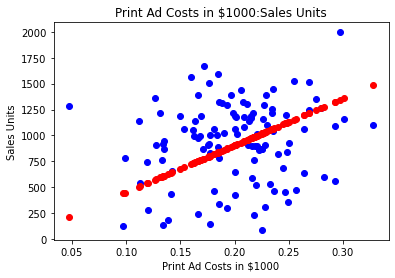

In [25]:
model_print_explorer = ModelExplorer(
    OLSModelPackage(
        'Print Ad Costs in $1000', X[['print_ads']], y, TESTSIZE_IN_PERCENT, RANDOM_SEED
    )
)
model_print_explorer.execute()

Judging from the R2 results, online ads have the greatest explanation for sales.
However, the RMSE on all is colossal. The print ads have a hint of
heteroskedacity?

## Nest 1, 2 and 3 revisited

We engineer the features to deal with non-linearity and some data imbalance.

<AxesSubplot:>

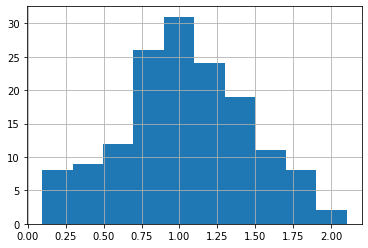

In [26]:
X1 = X.copy()
y1 = y.copy()

# Primo, online ads are skewed right. Log that sucker
#X1['online_ads'].hist()
#X1['online_ads'] = np.log(X1['online_ads']) # too much
X1['online_ads'] = np.sqrt(X1['online_ads']) # perfect!
X1['online_ads'].hist()


Evaluation
In Sample (training): rmse:369.91; r2:0.06; 
Hold Out (test): rmse:403.95; r2:0.05; 
Coefficients
Name                tv_ads              
TV Ad Costs, scaled 461.53              


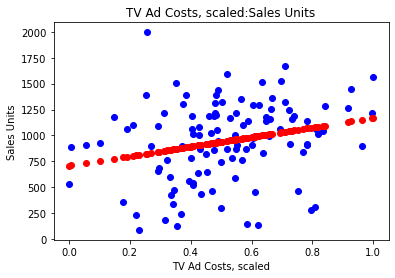

In [27]:
## Let's try TV Ads, scaled.
model_tv_explorer = ModelExplorer(
    LinearRegressionModelPackage(
        'TV Ad Costs, scaled', X1[['tv_ads']], y, TESTSIZE_IN_PERCENT, RANDOM_SEED
    )
)
model_tv_explorer.scale()
model_tv_explorer.execute()

Scaling did nothing for TV Ads. Perhaps Online Ads, now that it is standardized?


Evaluation
In Sample (training): rmse:230.79; r2:0.64; 
Hold Out (test): rmse:252.15; r2:0.63; 
Coefficients
Name                                online_ads                          
Online Ad Costs scaled and balanced 1451.17                             


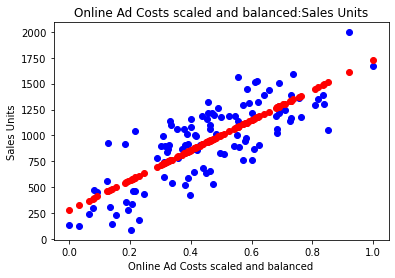

In [28]:
model_online_explorer = ModelExplorer(
    LinearRegressionModelPackage(
        'Online Ad Costs scaled and balanced', X1[['online_ads']], y, TESTSIZE_IN_PERCENT, RANDOM_SEED
    )
)
model_online_explorer.scale()
model_online_explorer.execute()

The balance improved the r2 by 2% for hold-out and 8% for in-sample. RMSE had
a small improvement as well.

                                 OLS Regression Results                                
Dep. Variable:            sales_units   R-squared (uncentered):                   0.943
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              1823.
Date:                Tue, 10 May 2022   Prob (F-statistic):                    1.03e-70
Time:                        23:22:46   Log-Likelihood:                         -774.76
No. Observations:                 112   AIC:                                      1552.
Df Residuals:                     111   BIC:                                      1554.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

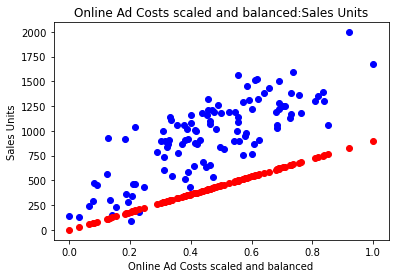

In [29]:
model_online_explorer = ModelExplorer(
   OLSModelPackage(
        'Online Ad Costs scaled and balanced', X1[['online_ads']], y, TESTSIZE_IN_PERCENT, RANDOM_SEED
    )
)
model_online_explorer.scale()
model_online_explorer.execute()

The OLS model here seems to not appreciate the new balance.

### Nest 4: Ad spending + controls

I am interested in Q4 for Black Friday/Christmas.

In [36]:
X2 = blender_data.drop(['sales_units'], axis=1)
y2 = blender_data[['sales_units']]

In [39]:
X2['month'] = X2['date'].dt.month
X2['year'] = X2['date'].dt.year


In [40]:
X2 = X2.drop(['date'], axis=1)

In [41]:
model_ads_controls = LinearRegressionModelPackage(
    'Ads and Controls, scaled', X2, y, TESTSIZE_IN_PERCENT, RANDOM_SEED
)
model_ads_controls.scale()
model_ads_controls.fit()
model_ads_controls_reporter = ModelReporter(model_ads_controls)
model_ads_controls_reporter.print_evaluation()
model_ads_controls_reporter.print_coefficients()


Evaluation
In Sample (training): rmse:88.29; r2:0.95; 
Hold Out (test): rmse:82.58; r2:0.96; 
Coefficients
Name                     price                    tv_ads                   online_ads               print_ads                month                    year                     
Ads and Controls, scaled -389.25                  347.52                   1423.06                  310.58                   -15.22                   -327.93                  


In [127]:
model_ads_controls = OLSModelPackage(
    'Ads and Controls, scaled', X2, y, TESTSIZE_IN_PERCENT, RANDOM_SEED
)
model_ads_controls.scale()
model_ads_controls.fit()
ols_model_reporter = ModelReporter(model_ads_controls)
ols_model_reporter.summary()
model = model_ads_controls
predict_y = model.predictions['in_sample']
print(f'\n Train:\n rmse: {mean_squared_error(model.train_y.values, predict_y, squared=False)}\n r2: {r2_score(model.train_y.values, predict_y)}')
predict_y = model.predictions['hold_out']
print(f'\n Test: \n rmse: {mean_squared_error(model.test_y.values, predict_y, squared=False)}\n r2: {r2_score(model.test_y.values, predict_y)}')

                                 OLS Regression Results                                
Dep. Variable:            sales_units   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              2321.
Date:                Wed, 11 May 2022   Prob (F-statistic):                   5.10e-110
Time:                        01:24:45   Log-Likelihood:                         -661.18
No. Observations:                 112   AIC:                                      1334.
Df Residuals:                     106   BIC:                                      1351.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

R2 is quite strong. So far, online ads followed by price are the biggest
influences. Print and TV are useful. Q4 has very little to do with the
sales.

## Adding pairwise to the mix

In [33]:
model_ads_controls_pairwise = LinearRegressionModelPackage(
    'Ads Controls Pairwise', X2, y, TESTSIZE_IN_PERCENT, RANDOM_SEED
)
model_ads_controls_pairwise.add_pairwise(['tv_ads', 'online_ads', 'print_ads'])
model_ads_controls_pairwise.scale()
model_ads_controls_pairwise.fit()
reporter = ModelReporter(model_ads_controls_pairwise)
reporter.print_evaluation()
reporter.print_coefficients()
model_ads_controls_pairwise.


Evaluation
In Sample (training): rmse:87.78; r2:0.95; 
Hold Out (test): rmse:83.50; r2:0.96; 
Coefficients
Name                  price                 tv_ads                online_ads            print_ads             Q4                    tv_ads:online_ads     tv_ads:print_ads      online_ads:print_ads  
Ads Controls Pairwise -714.38               99.50                 1470.96               -1145.79              -13.54                -30.30                1457.77               -19.18                


<ipython-input-10-899d1cc6dff0>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_X[f"{column_names[i]}:{column_names[j]}"] = \
<ipython-input-10-899d1cc6dff0>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_X[f"{column_names[i]}:{column_names[j]}"] = \


In [123]:
model_ads_controls_pairwise = OLSModelPackage(
    'Ads and Controls,Pairwise, scaled', X2, y, TESTSIZE_IN_PERCENT, RANDOM_SEED
)
model_ads_controls_pairwise.add_pairwise(['tv_ads', 'online_ads', 'print_ads'])
model_ads_controls_pairwise.scale()
model_ads_controls_pairwise.train_y.index = model_ads_controls_pairwise.train_X.index
model_ads_controls_pairwise.model = sm.OLS(model_ads_controls_pairwise.train_y, model_ads_controls_pairwise.train_X)
model_ads_controls_pairwise.fit()
ols_model_reporter = ModelReporter(model_ads_controls_pairwise)
ols_model_reporter.summary()
predict_y = model_ads_controls_pairwise.predictions['in_sample']
print(f'\n Train:\n rmse: {mean_squared_error(model_ads_controls_pairwise.train_y.values, predict_y, squared=False)}\n r2: {r2_score(model_ads_controls_pairwise.train_y.values, predict_y)}')
predict_y = model_ads_controls_pairwise.predictions['hold_out']
print(f'\n Test: \n rmse: {mean_squared_error(model_ads_controls_pairwise.test_y.values, predict_y, squared=False)}\n r2: {r2_score(model_ads_controls_pairwise.test_y.values, predict_y)}')

                                 OLS Regression Results                                
Dep. Variable:            sales_units   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              1186.
Date:                Wed, 11 May 2022   Prob (F-statistic):                   9.25e-100
Time:                        01:18:54   Log-Likelihood:                         -674.37
No. Observations:                 112   AIC:                                      1367.
Df Residuals:                     103   BIC:                                      1391.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

<ipython-input-105-3f52f108d38a>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_X[f"{column_names[i]}:{column_names[j]}"] = \
<ipython-input-105-3f52f108d38a>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_X[f"{column_names[i]}:{column_names[j]}"] = \


In [132]:
model_ads_controls_pairwise = OLSModelPackage(
    'Ads and Controls,Pairwise, scaled', X2, y, TESTSIZE_IN_PERCENT, RANDOM_SEED
)
model_ads_controls_pairwise.add_pairwise(['tv_ads', 'online_ads', 'print_ads'])
model_ads_controls_pairwise.scale()
model_ads_controls_pairwise.train_y.index = model_ads_controls_pairwise.train_X.index
model_ads_controls_pairwise.train_X = model_ads_controls_pairwise.train_X[['tv_ads', 'online_ads', 'print_ads', 'tv_ads:print_ads']]
model = sm.OLS(model_ads_controls_pairwise.train_y, model_ads_controls_pairwise.train_X)
model_ads_controls_pairwise.fit()
ols_model_reporter = ModelReporter(model_ads_controls_pairwise)
ols_model_reporter.summary()

model = model_ads_controls_pairwise
predict_y = model.predictions['in_sample']
print(f'\n Train:\n rmse: {mean_squared_error(model.train_y.values, predict_y, squared=False)}\n r2: {r2_score(model.train_y.values, predict_y)}')
predict_y = model.predictions['hold_out']
print(f'\n Test: \n rmse: {mean_squared_error(model.test_y.values, predict_y, squared=False)}\n r2: {r2_score(model.test_y.values, predict_y)}')

<ipython-input-105-3f52f108d38a>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_X[f"{column_names[i]}:{column_names[j]}"] = \
<ipython-input-105-3f52f108d38a>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_X[f"{column_names[i]}:{column_names[j]}"] = \


ValueError: shapes (112,4) and (6,) not aligned: 4 (dim 1) != 6 (dim 0)

In [78]:
model_ads_controls_pairwise = OLSModelPackage(
    'Ads and Controls,Pairwise, scaled', X2, y, TESTSIZE_IN_PERCENT, RANDOM_SEED
)
model_ads_controls_pairwise.add_pairwise(['tv_ads', 'online_ads', 'print_ads'])
model_ads_controls_pairwise.scale()
model_ads_controls_pairwise.train_y.index = model_ads_controls_pairwise.train_X.index
model_ads_controls_pairwise.train_X = model_ads_controls_pairwise.train_X[['tv_ads', 'online_ads']]
model = sm.OLS(model_ads_controls_pairwise.train_y, model_ads_controls_pairwise.train_X)
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:            sales_units   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              732.7
Date:                Wed, 11 May 2022   Prob (F-statistic):                    2.63e-64
Time:                        00:21:32   Log-Likelihood:                         -785.73
No. Observations:                 112   AIC:                                      1575.
Df Residuals:                     110   BIC:                                      1581.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<ipython-input-10-899d1cc6dff0>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_X[f"{column_names[i]}:{column_names[j]}"] = \
<ipython-input-10-899d1cc6dff0>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_X[f"{column_names[i]}:{column_names[j]}"] = \


In [80]:
# Remove scale

In [79]:
model_ads_controls = OLSModelPackage(
    'Ads and Controls', X2, y, TESTSIZE_IN_PERCENT, RANDOM_SEED
)
model_ads_controls.fit()
ols_model_reporter = ModelReporter(model_ads_controls)
ols_model_reporter.summary()

                                 OLS Regression Results                                
Dep. Variable:            sales_units   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              2321.
Date:                Wed, 11 May 2022   Prob (F-statistic):                   5.10e-110
Time:                        00:22:54   Log-Likelihood:                         -661.18
No. Observations:                 112   AIC:                                      1334.
Df Residuals:                     106   BIC:                                      1351.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [81]:
model_ads_controls_pairwise = OLSModelPackage(
    'Ads and Controls,Pairwise, scaled', X2, y, TESTSIZE_IN_PERCENT, RANDOM_SEED
)
model_ads_controls_pairwise.add_pairwise(['tv_ads', 'online_ads', 'print_ads'])
model_ads_controls_pairwise.train_y.index = model_ads_controls_pairwise.train_X.index
model_ads_controls_pairwise.model = sm.OLS(model_ads_controls_pairwise.train_y, model_ads_controls_pairwise.train_X)
model_ads_controls_pairwise.fit()
ols_model_reporter = ModelReporter(model_ads_controls_pairwise)
ols_model_reporter.summary()

                                 OLS Regression Results                                
Dep. Variable:            sales_units   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              1527.
Date:                Wed, 11 May 2022   Prob (F-statistic):                   2.30e-105
Time:                        00:26:25   Log-Likelihood:                         -660.33
No. Observations:                 112   AIC:                                      1339.
Df Residuals:                     103   BIC:                                      1363.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

<ipython-input-10-899d1cc6dff0>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_X[f"{column_names[i]}:{column_names[j]}"] = \
<ipython-input-10-899d1cc6dff0>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_X[f"{column_names[i]}:{column_names[j]}"] = \


In [88]:
model_ads_controls_pairwise = OLSModelPackage(
    'Ads and Controls,Pairwise, scaled', X2[['price', 'year']], y, TESTSIZE_IN_PERCENT, RANDOM_SEED
)
model_ads_controls_pairwise.fit()

ols_model_reporter = ModelReporter(model_ads_controls_pairwise)
ols_model_reporter.summary()

                                 OLS Regression Results                                
Dep. Variable:            sales_units   R-squared (uncentered):                   0.905
Model:                            OLS   Adj. R-squared (uncentered):              0.903
Method:                 Least Squares   F-statistic:                              522.1
Date:                Wed, 11 May 2022   Prob (F-statistic):                    7.11e-57
Time:                        00:31:27   Log-Likelihood:                         -803.15
No. Observations:                 112   AIC:                                      1610.
Df Residuals:                     110   BIC:                                      1616.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [89]:
# Standarization

In [91]:
model_ads_controls = OLSModelPackage(
    'Ads and Controls', X2, y, TESTSIZE_IN_PERCENT, RANDOM_SEED
)
model_ads_controls.standardize()
model_ads_controls.fit()
ols_model_reporter = ModelReporter(model_ads_controls)
ols_model_reporter.summary()

                                 OLS Regression Results                                
Dep. Variable:            sales_units   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              2321.
Date:                Wed, 11 May 2022   Prob (F-statistic):                   5.10e-110
Time:                        00:35:51   Log-Likelihood:                         -661.18
No. Observations:                 112   AIC:                                      1334.
Df Residuals:                     106   BIC:                                      1351.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [97]:
model_ads_controls = OLSModelPackage(
    'Ads and Controls', X2, y, TESTSIZE_IN_PERCENT, RANDOM_SEED
)
model_ads_controls.add_pairwise(['tv_ads', 'online_ads', 'print_ads'])
model_ads_controls.standardize()
model_ads_controls.model = sm.OLS(model_ads_controls.train_y, model_ads_controls.train_X)

model_ads_controls.fit()
ols_model_reporter = ModelReporter(model_ads_controls)
ols_model_reporter.summary()

                                 OLS Regression Results                                
Dep. Variable:            sales_units   R-squared (uncentered):                   0.133
Model:                            OLS   Adj. R-squared (uncentered):              0.057
Method:                 Least Squares   F-statistic:                              1.756
Date:                Wed, 11 May 2022   Prob (F-statistic):                      0.0858
Time:                        00:38:48   Log-Likelihood:                         -926.79
No. Observations:                 112   AIC:                                      1872.
Df Residuals:                     103   BIC:                                      1896.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<ipython-input-90-93d54bd57095>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_X[f"{column_names[i]}:{column_names[j]}"] = \
<ipython-input-90-93d54bd57095>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_X[f"{column_names[i]}:{column_names[j]}"] = \


# Add Koycks

## Additional Feature Engineering

In [ ]:
blender_data2 = add_pairwise(['tv_ads', 'online_ads', 'print_ads'], blender_data)
X2 = blender_data2.drop(['sales_units', 'date'], axis=1)
y2 = blender_data2[['sales_units']]
train_X2, test_X2, train_y2, test_y2 = train_test_split(
    X2, y2, test_size=(TESTSIZE_IN_PERCENT/100), random_state=RANDOM_SEED
)

In [ ]:
lr_models['pairwise'] = {
    'model': LinearRegression(),
    'X': train_X2,
    'y': train_y2
}
lr_models['pairwise']['model'].fit(train_X2, train_y2)

In [ ]:
# Let us evaluate the two different models

from sklearn.metrics import r2_score

pred_1 = lr_models['unengineered']['model'].predict(test_X)
pred_2 = lr_models['pairwise']['model'].predict(test_X2)

r2_1 = r2_score(test_y, pred_1)
r2_2 = r2_score(test_y2, pred_2)

print(r2_1)
print(r2_2)

It appears the unengineered model has better r2. Apparently the models are close to perfect???

In [ ]:
show_coefficients(lr_models)

OK, this is weird. Apparently with the new model:
  - Every dollar decrease in price pushes the sales up 15.86
  - Every thousand spent on TV with online has marginal decrease in sales
  - Every thousand spent on TV and print pushes sales up 25
  - Every thousand spent on print and online DECREASES sales by 17
  
Get rid of online sales quick?